In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from imutils import paths
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, efficientnet_b1, EfficientNet_B1_Weights
import json
from collections import Counter

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Create outputs folder
dir = "/content/drive/MyDrive/SHBT261/Project/"
save_dir = os.path.join(dir, "outputs/efficientnet_results")
os.makedirs(save_dir, exist_ok=True)

#### Load data and processing

In [3]:
# Load image and preprocess
img_dir = os.path.join(dir, "dataset/caltech-101")
image_paths = list(paths.list_images(img_dir))

data, labels = [], []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":  # remove this class
        continue
    labels.append(label)
    data.append(img_path)

# Encode labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)

print(f"Total Number of Classes: {len(lb.classes_)}")

100%|██████████| 9144/9144 [00:00<00:00, 1044065.87it/s]

Total Number of Classes: 101


In [4]:
# Define custom dataset
class CaltechDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

#### Split dataset and transform

In [5]:
# Hyperparameters and DataLoaders
image_size = 128       # 128 or 64
optimizer_name = "adam"  # "adam" or "sgd"
learning_rate = 1e-4
batch_size = 32
num_epochs = 30
patience = 5
weight_decay=1e-4

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Stratified split 70/15/15
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=seed
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=seed
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

train_dataset = CaltechDataset(train_paths, train_labels, train_transform)
val_dataset = CaltechDataset(val_paths, val_labels, val_transform)
test_dataset = CaltechDataset(test_paths, test_labels, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train: 6073, Val: 1302, Test: 1302


#### Model

选择 "last_block" 模式：
只解冻 features 中的最后两个层（EfficientNet 的倒数第二和倒数第一卷积模块）
这样做的目的是保持大部分预训练特征不变，仅微调末端特征提取器以适应新任务

EfficientNet 的 classifier 是一个两层结构（通常是 Dropout + Linear）
第 1 层是 nn.Linear(1280, 1000)（ImageNet 1000 类）
用你自己的类别数替换为 nn.Linear(in_features, num_classes)
这是迁移学习中必须做的步骤
解冻分类器层（即刚刚替换的新头）

EfficientNet-B0:
 ├── features (CNN 特征提取器)
 │   ├── features[0]
 │   ├── ...
 │   └── features[8]  ← 解冻的是 features[-2:] 即 [7, 8]
 └── classifier
     ├── Dropout
     └── Linear(in=1280, out=num_classes) ← 已替换

ResNet（如 ResNet-50）

BatchNorm 很多且稳定；

微调时一般不需要手动冻结 BN 统计量，因为 ResNet 的 BN 在迁移时较鲁棒；

常见做法：

model.train()  # 保持 BN 可更新


仅在 batch 很小时（<16）才建议冻结 BN。

✅ EfficientNet（尤其是 B0/B1/...）

BN 层非常多（每个 MBConv block 都有）；

EfficientNet 对 BN 统计非常敏感；

当你：

使用较小 batch size（<32）；

只解冻少量层（例如最后几层）；

使用较低学习率微调；

此时如果 BN 的 running mean/var 更新，会导致特征分布偏移 → 训练发散或不收敛。

🔒 因此 EfficientNet 微调时应冻结 BN 的 running mean/var。

Freezing Batch Normalization (BN) layers in EfficientNet during fine-tuning is a common practice to leverage the pre-trained statistics from the original dataset (e.g., ImageNet) and prevent the BN layers from adapting to smaller or different target datasets, which could lead to instability or suboptimal performance. (recommended for EfficientNet on small datasets)

In [6]:
# Freeze BatchNorm layers
def freeze_batchnorm(model, freeze_affine=True):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()  # Stop updating running_mean and running_var
            if freeze_affine:
                for p in m.parameters():
                    p.requires_grad = False

# Load and modify EfficientNet-B1
def get_efficientnet_b1(num_classes, fine_tune_blocks=2, freeze_bn=True):
    # Load pretrained EfficientNet-B1
    model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)

    # Freeze all model parameters by default
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last N feature blocks
    if fine_tune_blocks > 0:
        blocks_to_unfreeze = model.features[-fine_tune_blocks:]
        for param in blocks_to_unfreeze.parameters():
            param.requires_grad = True

    # Replace the classification head
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # Ensure classifier head is always trainable
    for p in model.classifier.parameters():
        p.requires_grad = True

    # Freeze BatchNorm behavior
    if freeze_bn:
        freeze_batchnorm(model, freeze_affine=False)

    return model

#### Train

In [7]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
# model training
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=30, patience=5, model_name="EfficientNetB1", optimizer_name="adam", img_size=64):
    # Filename with metadata
    save_name = f"{save_dir}/best_{model_name}_opt-{optimizer_name}_img-{img_size}.pth"

    best_val_acc = 0.0
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    # Initialize early stopping (based on validation loss)
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss /= total
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        val_acc = correct / total

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # Determine and update best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'model_name': model_name,
                'optimizer_name': optimizer_name,
                'image_size': img_size,
                'best_val_acc': best_val_acc,
                'epoch': epoch + 1
            }, save_name)
            print(f"Saved best model at epoch {epoch+1}")

        # Use early stopping to prevent overfitting
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val_acc = {best_val_acc:.4f}")
            break

    # ---- Plot curves ----
    plt.figure(figsize=(12,5))
    plt.plot(train_loss_hist, label='Training Loss')
    print(f"{model}, {optimizer}, {train_loss_hist}")
    plt.plot(val_loss_hist, label='Validation Loss')
    print(f"{model}, {optimizer}, {val_loss_hist}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve ({model_name}, {optimizer_name}, {image_size})')
    plt.legend()

    plt.savefig(f"{save_dir}/training_curves_{model_name}_opt-{optimizer_name}_img-{img_size}.png", dpi=300)
    plt.show()

    return model

In [9]:
num_classes = len(lb.classes_)
model = get_efficientnet_b1(num_classes=num_classes, fine_tune_blocks=2, freeze_bn=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only train parameters that require_grad=True
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

if optimizer_name.lower() == "adam":
    optimizer = optim.Adam(trainable_params, lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name.lower() == "sgd":
    optimizer = optim.SGD(trainable_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

#### Evaluation

In [10]:
# Model evaluation
def evaluate_model(model_path, model, test_loader, lb, save_dir="/content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results"):
    # === Load model checkpoint ===
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # === Inference ===
    y_test, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_test.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # === Metrics ===
    acc = accuracy_score(y_test, y_pred)
    top5_acc = top_k_accuracy_score(y_test, y_probs, k=5)
    report = classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True, digits=4, zero_division=0)

    # === Save metrics to JSON ===
    metrics = {
        "model": checkpoint.get("model_name", "Unknown"),
        "optimizer": checkpoint.get("optimizer_name", "Unknown"),
        "image_size": checkpoint.get("image_size", None),
        "overall_accuracy": acc,
        "top5_accuracy": top5_acc
        # "per_class_accuracy": {cls: report[cls]["recall"] for cls in lb.classes_}
    }
    os.makedirs(save_dir, exist_ok=True)
    results_path = os.path.join(save_dir, "eval_results.json")

    if os.path.exists(results_path):
        try:
            with open(results_path, "r") as f:
                all_results = json.load(f)
                if not isinstance(all_results, list):
                    all_results = [all_results]
        except json.JSONDecodeError:
            all_results = []
    else:
        all_results = []

    all_results.append(metrics)
    with open(results_path, "w") as f:
        json.dump(all_results, f, indent=4)

    print(f"Metrics appended to {results_path}")

    # === save classification_report （per-class accuracy = recall）===
    df_report = pd.DataFrame(report).transpose()
    os.makedirs(save_dir, exist_ok=True)
    csv_name = f"report_{checkpoint.get('model_name', 'Unknown')}_{checkpoint.get('optimizer_name', 'Unknown')}_{checkpoint.get('image_size', 'NA')}.csv"
    csv_path = os.path.join(save_dir, csv_name)

    df_report.to_csv(csv_path, index=True)
    print(f"Classification report saved to {csv_path}")

    # === Confusion Matrix ===
    # Top 10 hardest classes
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    errors = np.sum(cm, axis=1) - np.diag(cm)
    top_idx = np.argsort(errors)[-10:]  # Top 15 hardest classes
    cm_focus = cm_norm[np.ix_(top_idx, top_idx)]
    labels_focus = [lb.classes_[i] for i in top_idx]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_focus, cmap='Purples', xticklabels=labels_focus, yticklabels=labels_focus, annot=True, fmt=".2f")
    # plt.title(f"Confusion Matrix - Top 10 hardest classes ({metrics['model']} | {metrics['optimizer']} | {metrics['image_size']})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    cm_filename = os.path.join(save_dir, f"confusion_matrix_{metrics['model']}_{metrics['optimizer']}_{metrics['image_size']}.png")
    plt.savefig(cm_filename, dpi=300)
    plt.close()

    print(f"Confusion matrix saved to {cm_filename}")

    return metrics

In [ ]:
# optimizer: sgd, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="EfficientNetB1", optimizer_name="sgd",img_size=128)

In [ ]:
# optimizer: sgd, image_size: 128
metrics = evaluate_model(model_path=f"{save_dir}/best_EfficientNetB1_opt-sgd_img-128.pth", model=model, test_loader=test_loader, lb=lb)

#### Ablation Studies

In [ ]:
# optimizer: sgd, image_size: 64
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="EfficientNetB1", optimizer_name="sgd",img_size=64)
metrics = evaluate_model(model_path=f"{save_dir}/best_EfficientNetB1_opt-sgd_img-64.pth", model=model, test_loader=test_loader, lb=lb)

Epoch 1/30 [Val]: 100%|██████████| 41/41 [00:12<00:00,  3.34it/s]


Epoch 1: Train Loss=3.6272, Val Loss: 2.4259, Train Acc=0.4031, Val Acc=0.6851
Saved best model at epoch 1


Epoch 2/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.08it/s]


Epoch 2: Train Loss=1.7208, Val Loss: 1.1227, Train Acc=0.6967, Val Acc=0.7926
Saved best model at epoch 2


Epoch 3/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


Epoch 3: Train Loss=0.9271, Val Loss: 0.6944, Train Acc=0.8220, Val Acc=0.8518
Saved best model at epoch 3


Epoch 4/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


Epoch 4: Train Loss=0.6322, Val Loss: 0.5526, Train Acc=0.8739, Val Acc=0.8748
Saved best model at epoch 4


Epoch 5/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.10it/s]


Epoch 5: Train Loss=0.4818, Val Loss: 0.4912, Train Acc=0.8994, Val Acc=0.8810
Saved best model at epoch 5


Epoch 6/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.10it/s]


Epoch 6: Train Loss=0.3886, Val Loss: 0.4136, Train Acc=0.9136, Val Acc=0.8940
Saved best model at epoch 6


Epoch 7/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.08it/s]


Epoch 7: Train Loss=0.3210, Val Loss: 0.3876, Train Acc=0.9285, Val Acc=0.8994
Saved best model at epoch 7


Epoch 8/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


Epoch 8: Train Loss=0.2807, Val Loss: 0.3906, Train Acc=0.9358, Val Acc=0.8940


Epoch 9/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


Epoch 9: Train Loss=0.2438, Val Loss: 0.3522, Train Acc=0.9430, Val Acc=0.8978


Epoch 10/30 [Val]: 100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


Epoch 10: Train Loss=0.2068, Val Loss: 0.3598, Train Acc=0.9521, Val Acc=0.9025
Saved best model at epoch 10


Epoch 11/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


Epoch 11: Train Loss=0.1870, Val Loss: 0.3382, Train Acc=0.9562, Val Acc=0.9124
Saved best model at epoch 11


Epoch 12/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


Epoch 12: Train Loss=0.1544, Val Loss: 0.3266, Train Acc=0.9643, Val Acc=0.9147
Saved best model at epoch 12


Epoch 13/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


Epoch 13: Train Loss=0.1396, Val Loss: 0.3236, Train Acc=0.9697, Val Acc=0.9094


Epoch 14/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


Epoch 14: Train Loss=0.1255, Val Loss: 0.3186, Train Acc=0.9730, Val Acc=0.9132


Epoch 15/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


Epoch 15: Train Loss=0.1128, Val Loss: 0.3147, Train Acc=0.9746, Val Acc=0.9124


Epoch 16/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


Epoch 16: Train Loss=0.0999, Val Loss: 0.3286, Train Acc=0.9806, Val Acc=0.9063


Epoch 17/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.03it/s]


Epoch 17: Train Loss=0.0949, Val Loss: 0.3206, Train Acc=0.9812, Val Acc=0.9171
Saved best model at epoch 17


Epoch 18/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


Epoch 18: Train Loss=0.0857, Val Loss: 0.3127, Train Acc=0.9812, Val Acc=0.9101


Epoch 19/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.07it/s]


Epoch 19: Train Loss=0.0835, Val Loss: 0.3124, Train Acc=0.9821, Val Acc=0.9094


Epoch 20/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


Epoch 20: Train Loss=0.0774, Val Loss: 0.3250, Train Acc=0.9840, Val Acc=0.9094


Epoch 21/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


Epoch 21: Train Loss=0.0648, Val Loss: 0.3168, Train Acc=0.9857, Val Acc=0.9086


Epoch 22/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


Epoch 22: Train Loss=0.0619, Val Loss: 0.3173, Train Acc=0.9890, Val Acc=0.9117


Epoch 23/30 [Val]: 100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


Epoch 23: Train Loss=0.0593, Val Loss: 0.3139, Train Acc=0.9865, Val Acc=0.9178
Saved best model at epoch 23
Early stopping triggered at epoch 23. Best val_acc = 0.9178
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 3

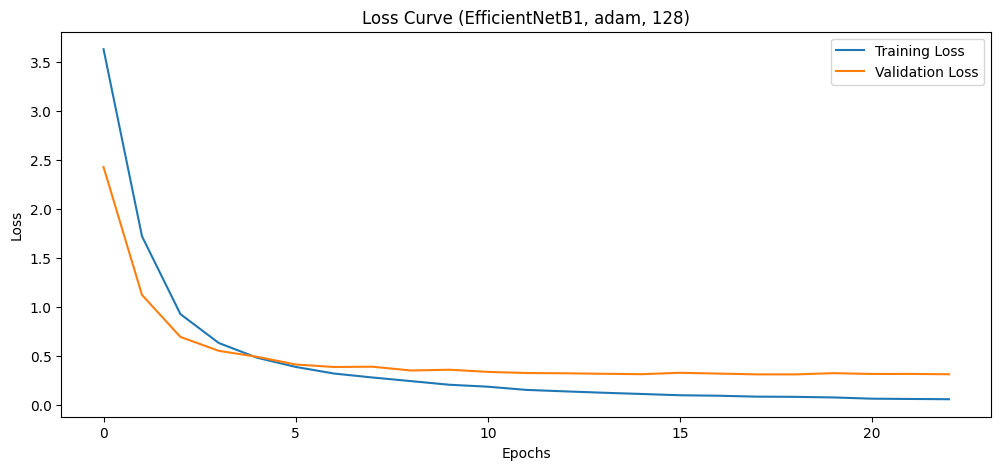

Testing: 100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


Metrics appended to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/eval_results.json
Classification report saved to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/report_EfficientNetB1_adam_128.csv
Confusion matrix saved to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/confusion_matrix_EfficientNetB1_adam_128.png


In [11]:
# optimizer: adam, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="EfficientNetB1", optimizer_name="adam",img_size=128)
metrics = evaluate_model(model_path=f"{save_dir}/best_EfficientNetB1_opt-adam_img-128.pth", model=model, test_loader=test_loader, lb=lb)

Epoch 1/30 [Val]: 100%|██████████| 41/41 [04:11<00:00,  6.13s/it]


Epoch 1: Train Loss=3.3831, Val Loss: 2.5898, Train Acc=0.3684, Val Acc=0.5622
Saved best model at epoch 1


Epoch 2/30 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


Epoch 2: Train Loss=2.1622, Val Loss: 1.6440, Train Acc=0.6088, Val Acc=0.7012
Saved best model at epoch 2


Epoch 3/30 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s]


Epoch 3: Train Loss=1.4035, Val Loss: 1.1298, Train Acc=0.7303, Val Acc=0.7634
Saved best model at epoch 3


Epoch 4/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


Epoch 4: Train Loss=0.9563, Val Loss: 0.8505, Train Acc=0.8115, Val Acc=0.8149
Saved best model at epoch 4


Epoch 5/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.47it/s]


Epoch 5: Train Loss=0.7246, Val Loss: 0.7234, Train Acc=0.8513, Val Acc=0.8349
Saved best model at epoch 5


Epoch 6/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.47it/s]


Epoch 6: Train Loss=0.5694, Val Loss: 0.6372, Train Acc=0.8780, Val Acc=0.8525
Saved best model at epoch 6


Epoch 7/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.69it/s]


Epoch 7: Train Loss=0.4712, Val Loss: 0.5638, Train Acc=0.8999, Val Acc=0.8679
Saved best model at epoch 7


Epoch 8/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


Epoch 8: Train Loss=0.3802, Val Loss: 0.5503, Train Acc=0.9195, Val Acc=0.8694
Saved best model at epoch 8


Epoch 9/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


Epoch 9: Train Loss=0.3456, Val Loss: 0.5477, Train Acc=0.9215, Val Acc=0.8648


Epoch 10/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


Epoch 10: Train Loss=0.2949, Val Loss: 0.5095, Train Acc=0.9369, Val Acc=0.8725
Saved best model at epoch 10


Epoch 11/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.46it/s]


Epoch 11: Train Loss=0.2560, Val Loss: 0.5167, Train Acc=0.9402, Val Acc=0.8756
Saved best model at epoch 11


Epoch 12/30 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.77it/s]


Epoch 12: Train Loss=0.2323, Val Loss: 0.5059, Train Acc=0.9518, Val Acc=0.8656


Epoch 13/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.70it/s]


Epoch 13: Train Loss=0.2006, Val Loss: 0.4875, Train Acc=0.9559, Val Acc=0.8771
Saved best model at epoch 13


Epoch 14/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.69it/s]


Epoch 14: Train Loss=0.1789, Val Loss: 0.4749, Train Acc=0.9636, Val Acc=0.8848
Saved best model at epoch 14


Epoch 15/30 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.73it/s]


Epoch 15: Train Loss=0.1566, Val Loss: 0.4941, Train Acc=0.9644, Val Acc=0.8733


Epoch 16/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


Epoch 16: Train Loss=0.1393, Val Loss: 0.4773, Train Acc=0.9702, Val Acc=0.8833


Epoch 17/30 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s]


Epoch 17: Train Loss=0.1348, Val Loss: 0.4827, Train Acc=0.9690, Val Acc=0.8802


Epoch 18/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.66it/s]


Epoch 18: Train Loss=0.1142, Val Loss: 0.4827, Train Acc=0.9758, Val Acc=0.8771


Epoch 19/30 [Val]: 100%|██████████| 41/41 [00:11<00:00,  3.71it/s]


Epoch 19: Train Loss=0.1089, Val Loss: 0.4928, Train Acc=0.9778, Val Acc=0.8794
Early stopping triggered at epoch 19. Best val_acc = 0.8848
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride

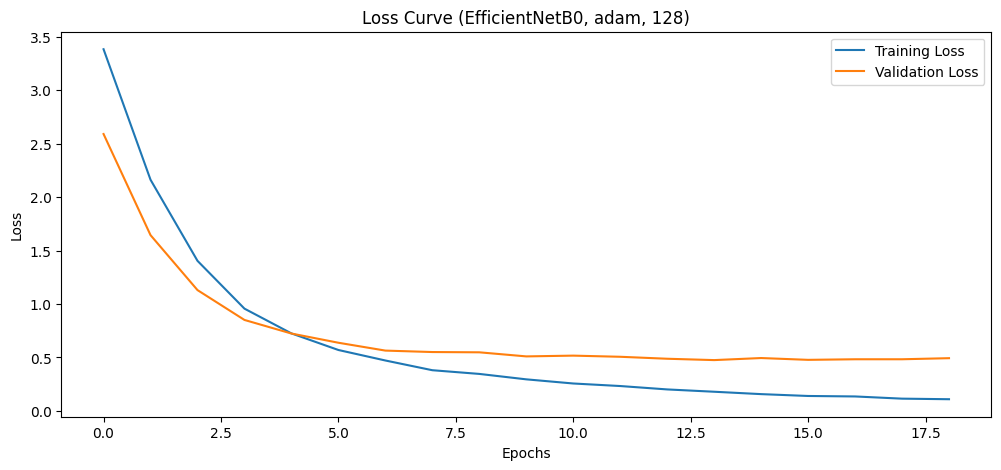

Testing: 100%|██████████| 41/41 [04:10<00:00,  6.12s/it]


Metrics appended to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/eval_results.json
Classification report saved to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/report_EfficientNetB0_adam_128.csv
Confusion matrix saved to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/confusion_matrix_EfficientNetB0_adam_128.png


In [12]:
# optimizer: adam, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="EfficientNetB1", optimizer_name="adam",img_size=128)
metrics = evaluate_model(model_path=f"{save_dir}/best_EfficientNetB1_opt-adam_img-128.pth", model=model, test_loader=test_loader, lb=lb)

Epoch 1/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.68it/s]


Epoch 1: Train Loss=4.4085, Val Loss: 4.1164, Train Acc=0.1599, Val Acc=0.3157
Saved best model at epoch 1


Epoch 2/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.68it/s]


Epoch 2: Train Loss=3.8787, Val Loss: 3.5773, Train Acc=0.3232, Val Acc=0.3287
Saved best model at epoch 2


Epoch 3/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.59it/s]


Epoch 3: Train Loss=3.3364, Val Loss: 3.2346, Train Acc=0.3443, Val Acc=0.3556
Saved best model at epoch 3


Epoch 4/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.71it/s]


Epoch 4: Train Loss=2.9789, Val Loss: 2.9426, Train Acc=0.3782, Val Acc=0.4055
Saved best model at epoch 4


Epoch 5/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.98it/s]


Epoch 5: Train Loss=2.6828, Val Loss: 2.6773, Train Acc=0.4334, Val Acc=0.4555
Saved best model at epoch 5


Epoch 6/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.01it/s]


Epoch 6: Train Loss=2.4174, Val Loss: 2.4822, Train Acc=0.4946, Val Acc=0.5108
Saved best model at epoch 6


Epoch 7/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.91it/s]


Epoch 7: Train Loss=2.1965, Val Loss: 2.1709, Train Acc=0.5347, Val Acc=0.5515
Saved best model at epoch 7


Epoch 8/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.81it/s]


Epoch 8: Train Loss=1.9667, Val Loss: 2.0635, Train Acc=0.5821, Val Acc=0.5760
Saved best model at epoch 8


Epoch 9/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.82it/s]


Epoch 9: Train Loss=1.8130, Val Loss: 2.0221, Train Acc=0.6063, Val Acc=0.6022
Saved best model at epoch 9


Epoch 10/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.80it/s]


Epoch 10: Train Loss=1.6662, Val Loss: 1.9273, Train Acc=0.6386, Val Acc=0.6190
Saved best model at epoch 10


Epoch 11/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.88it/s]


Epoch 11: Train Loss=1.5501, Val Loss: 1.7530, Train Acc=0.6580, Val Acc=0.6267
Saved best model at epoch 11


Epoch 12/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.93it/s]


Epoch 12: Train Loss=1.4286, Val Loss: 1.5637, Train Acc=0.6740, Val Acc=0.6452
Saved best model at epoch 12


Epoch 13/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.89it/s]


Epoch 13: Train Loss=1.3620, Val Loss: 1.6717, Train Acc=0.6843, Val Acc=0.6429


Epoch 14/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.83it/s]


Epoch 14: Train Loss=1.3037, Val Loss: 1.5694, Train Acc=0.6937, Val Acc=0.6544
Saved best model at epoch 14


Epoch 15/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.82it/s]


Epoch 15: Train Loss=1.2404, Val Loss: 1.4660, Train Acc=0.7046, Val Acc=0.6636
Saved best model at epoch 15


Epoch 16/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.78it/s]


Epoch 16: Train Loss=1.1737, Val Loss: 1.6987, Train Acc=0.7201, Val Acc=0.6621


Epoch 17/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.78it/s]


Epoch 17: Train Loss=1.1584, Val Loss: 1.4236, Train Acc=0.7214, Val Acc=0.6720
Saved best model at epoch 17


Epoch 18/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.89it/s]


Epoch 18: Train Loss=1.1002, Val Loss: 1.5272, Train Acc=0.7328, Val Acc=0.6759
Saved best model at epoch 18


Epoch 19/30 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.88it/s]


Epoch 19: Train Loss=1.0666, Val Loss: 1.4490, Train Acc=0.7403, Val Acc=0.6697


Epoch 20/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.66it/s]


Epoch 20: Train Loss=1.0589, Val Loss: 1.7697, Train Acc=0.7392, Val Acc=0.6713


Epoch 21/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.74it/s]


Epoch 21: Train Loss=1.0068, Val Loss: 1.4641, Train Acc=0.7542, Val Acc=0.6805
Saved best model at epoch 21


Epoch 22/30 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.70it/s]


Epoch 22: Train Loss=0.9807, Val Loss: 1.5839, Train Acc=0.7573, Val Acc=0.6851
Saved best model at epoch 22
Early stopping triggered at epoch 22. Best val_acc = 0.6851
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 3

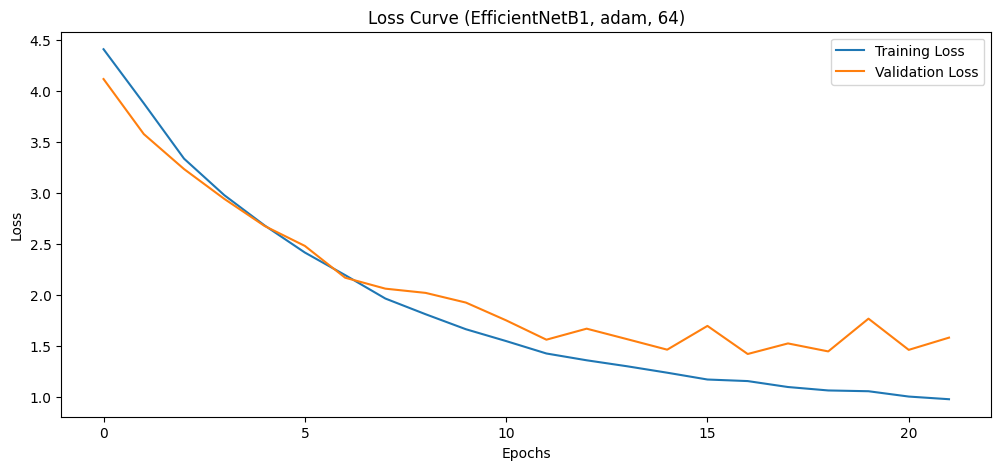

Testing: 100%|██████████| 41/41 [00:06<00:00,  5.92it/s]


Metrics appended to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/eval_results.json
Classification report saved to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/report_EfficientNetB1_adam_64.csv
Confusion matrix saved to /content/drive/MyDrive/SHBT261/Project/outputs/efficientnet_results/confusion_matrix_EfficientNetB1_adam_64.png


In [11]:
# optimizer: adam, image_size: 64
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="EfficientNetB1", optimizer_name="adam",img_size=64)
metrics = evaluate_model(model_path=f"{save_dir}/best_EfficientNetB1_opt-adam_img-64.pth", model=model, test_loader=test_loader, lb=lb)